In [20]:
# %pip install rastervision==
# %pip install rasterio
# %pip install gdown
# %pip install utils

In [21]:
import gdown
import glob
import utils

from rastervision.core.data import RasterioSource, MinMaxTransformer

from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

from rastervision.core.data import SemanticSegmentationLabelSource

from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner


In [22]:
import os
import subprocess
import rastervision
import rasterio
from subprocess import check_output
# os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
# os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'


# Get the location of rasterio
rasterio_location = check_output('pip show rasterio', shell=True).decode()

# Find the line that specifies the location
gdal_data_path = None
for line in rasterio_location.splitlines():
    if line.startswith("Location:"):
        gdal_data_path = os.path.join(line.split(":", 1)[1].strip(), 'rasterio', 'gdal_data')
        break

# Set the GDAL_DATA environment variable if we found the path
if gdal_data_path:
    os.environ['GDAL_DATA'] = gdal_data_path
    print(f"GDAL_DATA has been set to: {gdal_data_path}")
else:
    print("Could not find the GDAL data path.")


GDAL_DATA has been set to: C:\Users\oltie\anaconda3\envs\ssmodel_env\Lib\site-packages\rasterio\gdal_data


In [23]:
import random
import numpy as np
import torch

# Set global seed for reproducibility
def set_global_seed(seed):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy's random module
    torch.manual_seed(seed)  # PyTorch seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch seed for current GPU
        torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multi-GPU)

# Prepare cuDNN for deterministic behavior
def prepare_cudnn(deterministic=True):
    torch.backends.cudnn.deterministic = deterministic  # cuDNN deterministic setting
    torch.backends.cudnn.benchmark = not deterministic  # Disable cuDNN benchmarking if deterministic

# Set the seed and configure cuDNN
SEED = 42
set_global_seed(SEED)
prepare_cudnn(deterministic=True)


In [24]:
val_images_uri = "./data/val/img/2020.tif"
val_labels_uri = "./data/val/labels/barrios_3dfeb_lamtz.geojson"
train_images_uri ="./data/train/img/2021.tif"
train_labelss_uri = "./data/train/labels/barrios_3dfeb_lamtz.geojson"
AoI_file_dest_uri = "./data/aoi/AoI_3dfeb_LaMtz.geojson"

In [25]:
# Aquí definimos las clases (tipos de objeto) presentes en nuestras anotaciones
# en este caso tenemos sólo una, que indicamos como "basural" .
# hay un clase adicional, implícita, que es "background" -el fondo, todo lo que
# no corresponde a objetos de intéres

class_config = ClassConfig(
    names=['background', 'viviendas precaria'],
    colors=['lightgray', 'darkred'],
    null_class='background')


# el tamaño en píxeles de los recortes cuadrados
window_size = 64

# Aquí definimos algunas transformaciones a realizar a los recorte del dataset
# de entrenamiento: cambiar al azar la saturación, el brillo, rotarlos, ocultar
# algunos pixeles. Todo esto sirve para entrenar un algoritmo de detección
# más robusto a diferencias que puedan tener las futuras imágenes a las que
# se aplique
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
])


In [26]:
# data_augmentation_transform = A.Compose([
#     A.Flip(),
#     A.ShiftScaleRotate(),
#     A.OneOf([
#         A.HueSaturationValue(hue_shift_limit=10),
#         A.RGBShift(),
#         A.ToGray(),
#         A.ToSepia(),
#         A.RandomBrightnessContrast(),
#         A.RandomGamma(),
#     ]),
#     A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
# ])


In [27]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    aoi_uri=AoI_file_dest_uri,
    image_uri=val_images_uri,
    label_vector_uri=val_labels_uri,
    label_vector_default_class_id=class_config.get_class_id('viviendas precaria'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    size=window_size,
    stride=window_size,
    transform=A.Resize(window_size, window_size))

In [28]:
len(val_ds)

773

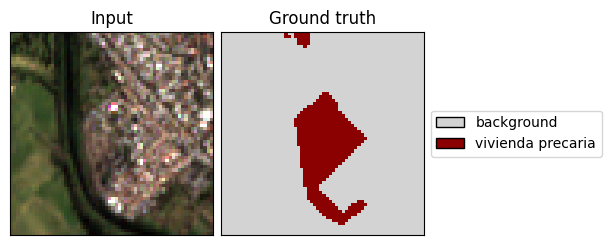

In [29]:
vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = val_ds[10]

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

In [30]:
# Aquí definimos cuantos recortes sobre la imagen tomaremos al azar
# idealmente, varias veces la cantidad de recortes en el dataset de validación
# (algo así como sample_size = len(val_ds) * 5
# pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
sample_size = len(val_ds)*5

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    aoi_uri=AoI_file_dest_uri,
    image_uri=train_images_uri,
    label_vector_uri=train_labelss_uri,
    label_vector_default_class_id=class_config.get_class_id('viviendas precaria'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    # window sizes will randomly vary from 100x100 to 300x300
    #size_lims=(100, 300),
    # fixed window size
    size_lims=(window_size, window_size+1),
    # resize chips before returning
    out_size=window_size,
    # allow windows to overflow the extent by 100 pixels
    padding=100,
    max_windows=sample_size, # pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
    transform=data_augmentation_transform
)

In [31]:
from torch.utils.data import Dataset

class LongTargetDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        y = y.long()  # Ensure target is LongTensor
        return x, y

In [39]:
# Wrap train and validation datasets
train_ds = LongTargetDataset(train_ds)
val_ds = LongTargetDataset(val_ds)

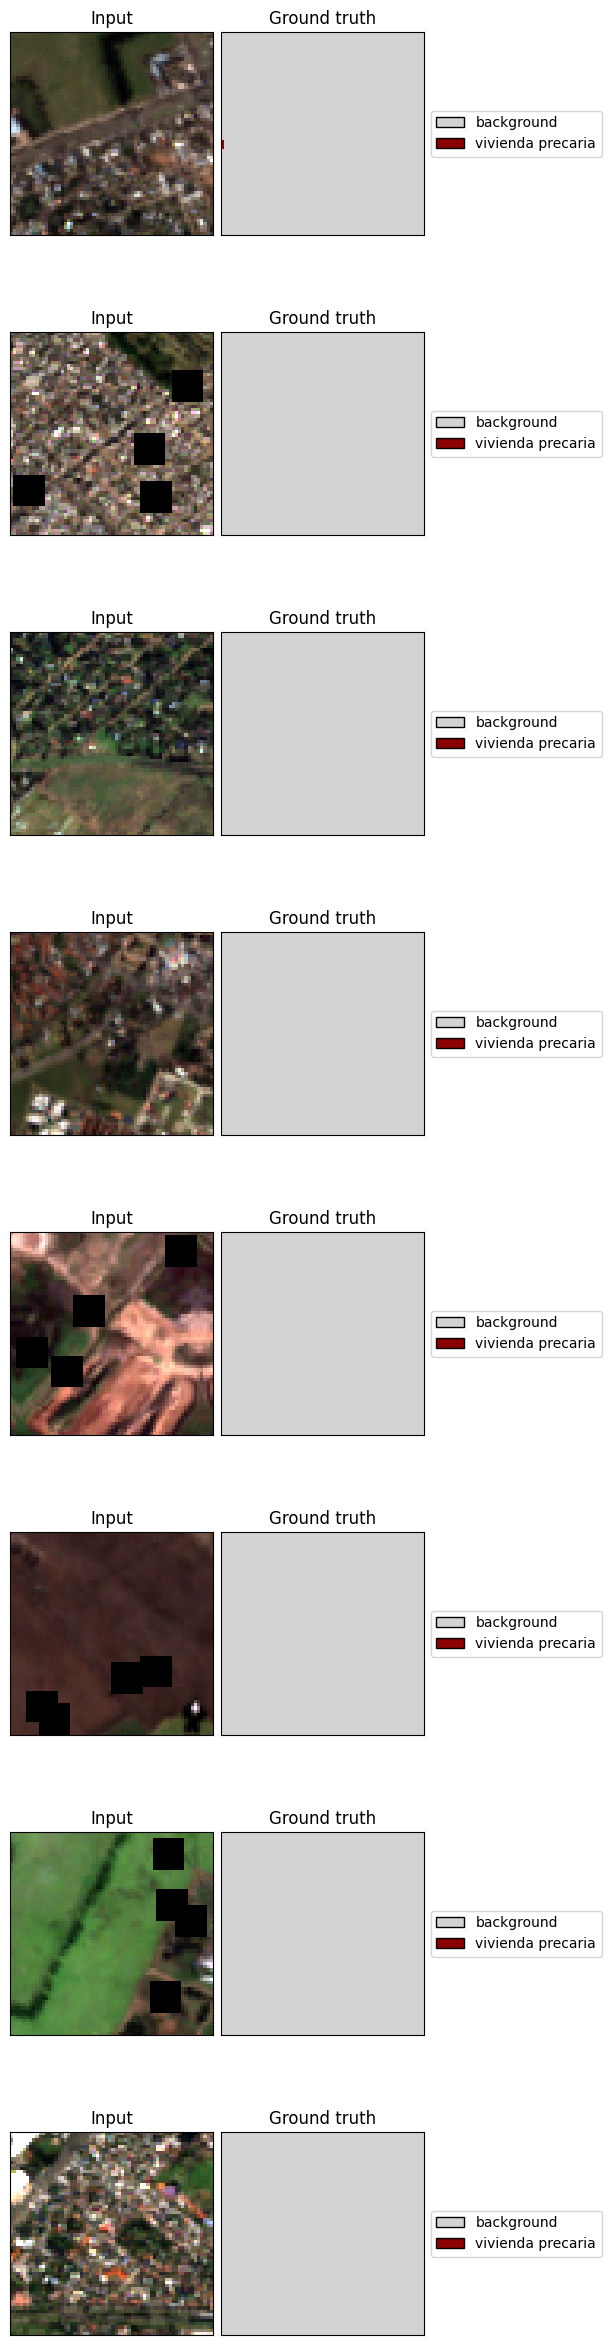

In [33]:
x, y = vis.get_batch(train_ds, 8)

vis.plot_batch(x, y, show=True)

Use model a light-weight panoptic FPN model with a ResNet-18 backbone. (extract from https://github.com/AdeelH/pytorch-fpn)

In [34]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True)


Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3


In [40]:
# cantidad de iteraciones
n_epochs = 100
# Donde vamos a guardar el modelo entrenado
model_folder = f"./data/models/bundle_{n_epochs}/"

# cantidad de imagenes a cargar por iteración
# (limitada por la cantidad de memoria GPU y de memoria RAM)
# en los 15Gb RAM de la GPU de Google Colab entran tandas
# de hasta 60 imagenes de 480x480px

batch_images = 50

# Configuración de clases a identificar
data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0,  # incrementar este valor habilita multiproceso, pero causa problemas en Colab
)

# Cuántas imágenes a cargar en memoria a la vez
solver_cfg = SolverConfig(
    batch_sz=batch_images,
    lr=0.01
)

# Combinamos todas las opciones en un objeto "learner", que es el que realizará el entrenamiento
learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir=model_folder,
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2024-10-09 10:27:54:rastervision.pytorch_learner.learner: INFO - Building dataloaders
2024-10-09 10:27:54:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./data/model/bundle_100/last-model.pth


In [ ]:
%load_ext tensorboard

In [ ]:
logdir = f"./data/models/bundle_{n_epochs}/tb-logs"
%tensorboard --bind_all --logdir $logdir --reload_interval 10

In [41]:
# Inicia el entrenamiento
learner.train(epochs=n_epochs)

2024-10-09 10:27:58:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 100
2024-10-09 10:27:58:rastervision.pytorch_learner.learner: INFO - train_ds: 3865 items
2024-10-09 10:27:58:rastervision.pytorch_learner.learner: INFO - valid_ds: 773 items
2024-10-09 10:27:58:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-10-09 10:28:03:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-10-09 10:28:06:rastervision.pytorch_learner.learner: INFO - epoch: 100
Training:   5%|▌         | 4/78 [00:03<01:06,  1.11it/s]


KeyboardInterrupt: 

2024-10-09 11:16:20:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


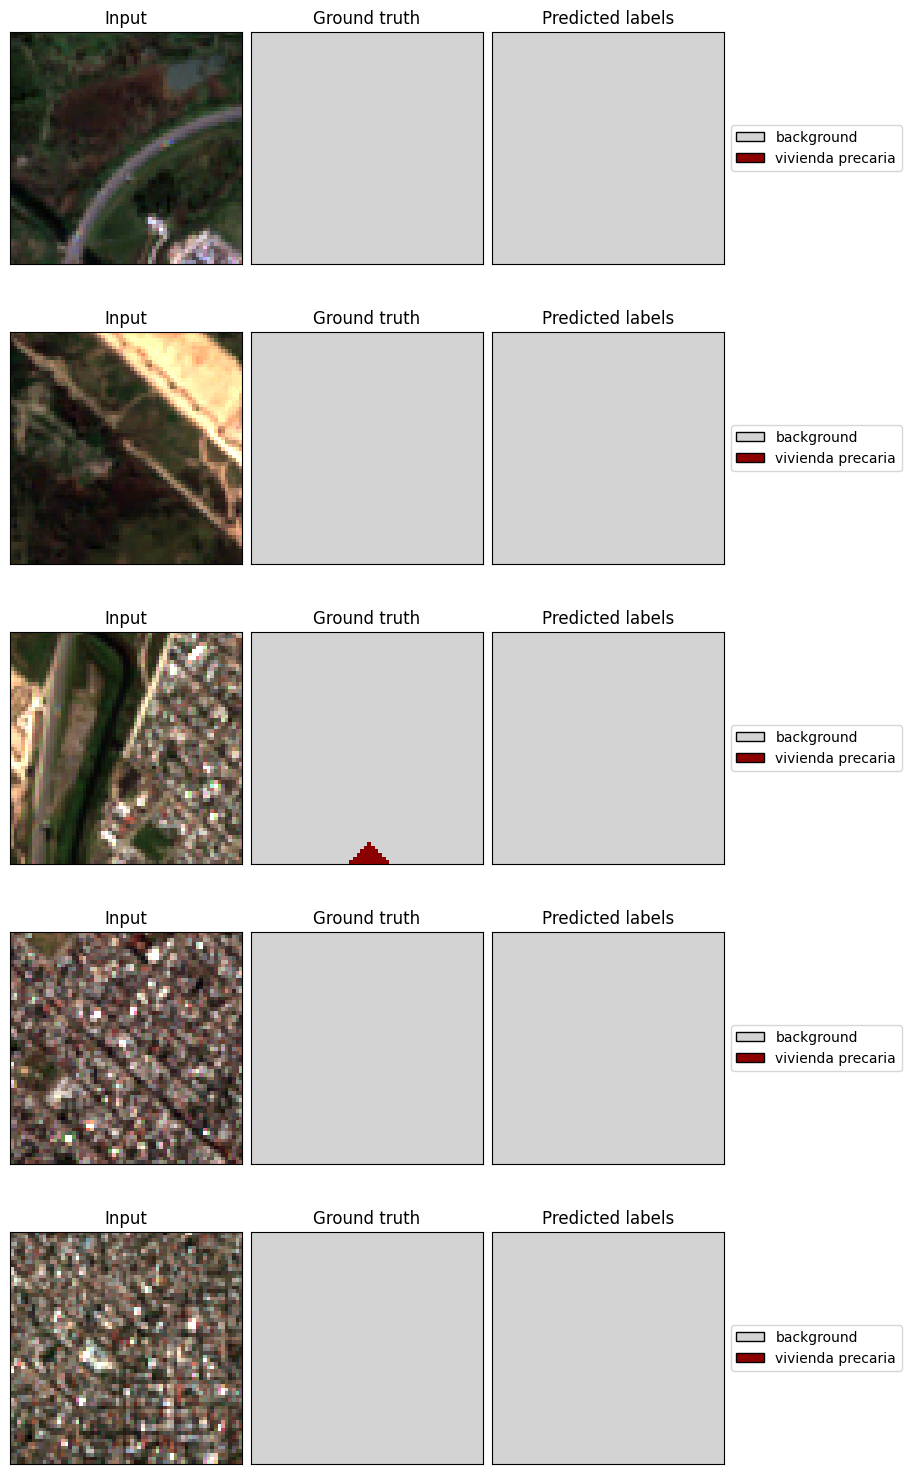

2024-10-09 11:16:21:rastervision.pytorch_learner.learner: INFO - Sample predictions written to ./data/model/bundle_100/valid_preds.png.


In [47]:
learner.plot_predictions(split='valid', show=True,batch_limit=5)

In [19]:
learner.save_model_bundle()

2024-10-08 23:46:01:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-10-08 23:46:01:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2024-10-08 23:46:02:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2024-10-08 23:46:03:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./data/model/bundle_100/model-bundle.zip.
Zipping: 2it [00:01,  1.02it/s, model.pth]      

# fine-tunning de un modelo ya usado

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri=f'data/models/bundle_{n_epochs}/model-bundle_{n_epochs}.zip',
    output_dir=f'data/models/bundle_{n_epochs}_extra/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)